# Prédiction de la qualtité de l'air dans les villes de France métropolitaine à partir de données socio-économiques

Aymeric Lelièvre et Théo Sannier

## Introduction

qualité de l'air préoccupation croissante
périph de Paris à 50km/h
seuils de l'oms (revus en 2021)
-> notre sujet

## Installation : installer requirements ?????

Commençons par importer les bibliothèques principales pour le traitement de données, la visualisation et la modélisation, ainsi que les scripts contenants les fonctions les plus volumineuses.

In [52]:
!pip install cartiflette

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [cartiflette]


In [ ]:
# 1. Configuration et Imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cartiflette import carti_download
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import warnings
from scripts import preprocessing as prep
from scripts import descriptive_visualization as viz
from scripts import add_city_columns_insee
from scripts import pol_visualization

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
viz.setup_styles()

print("Environnement chargé avec succès.")

Environnement chargé avec succès.


## Partie 1 : Préparation et analyse descriptive des données

Notre étude repose sur 3 jeux de données. Le premier est une base de données sur la qualité de l'air en France téléchargée sur le site Geod'air. Les 2 autres sont issus du site de l'INSEE et portent sur les caractéristiques démographiques et économiques (démo-éco dans la suite) des villes françaises.

Les données démo-éco ne sont toutefois pas disponibles pour chaque année sur le site de l'INSEE. Nous avons ainsi récupéré des données qui datent de 2021, 2022 ou 2023. Afin de correspondre au mieux à ces données, nous avons téléchargé sur Geod'air une moyenne annuelle de la pollution sur l'année 2022. L'hypothèse que les données démo-éco des villes françaises ne varient pas significativement d'une année sur l'autre nous semble raisonnable, et garantit la pertinence de notre étude.

In [2]:
# Chemin d'accès aux données

path_air = "data/raw_data/data_air_2022.csv"
path_villes = "data/raw_data/data.csv"
path_tourisme = "data/raw_data/BDD_tourisme_communes_2022.csv"

### a) Qualité de l'air

#### Chargement et préparation des données

Les données sur la qualité de l'air ont été chargées sur le site Geod'air qui concentre un certains nombre de stations de mesure de la pollution. Nous nous concentrons sur l'étude des 4 polluants comportant le plus de stations de mesure en France : NOX as NO2, O3, PM2.5, et PM10.

In [42]:
geodair = pd.read_csv(path_air, sep=";")
geodair

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO OCCITANIE,FR76ZAG02,ZAG MONTPELLIER,FR50225,Montpellier Liberté,Urbaine,PM2.5,Trafic,Oui,mesures fixes,Moy. annuelle,9.0,9.322676,µg-m3,99.0,54.0,53.0,N,-1,43.611606,3.827868
1137,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR03,ZAR BESANCON,FR82006,Besançon Prévoyance,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.597722,µg-m3,98.0,100.0,98.0,R,1,47.247400,6.015419
1138,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR01,ZAR BELFORT-MONTBELIARD,FR82010,Montbéliard centre,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.885362,µg-m3,97.0,100.0,97.0,R,1,47.510307,6.794000
1139,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82050,Lons-le-Saunier CV,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,7.0,7.268856,µg-m3,99.0,100.0,99.0,R,1,46.671321,5.556620


Afin de pouvoir, à l'avenir, fusionner cette base de données avec les données démographiques et économiques des villes, il nous faut le code INSEE de la ville de chacune des stations de mesure recensée sur le site Geod'air. 

Ce code INSEE peut être obtenu à partir des coordonnées d'une station de mesure grâce à l'api de data.gouv.fr disponible à l'adresse suivante : https://api-adresse.data.gouv.fr/reverse

La cellule suivante ajoute un colonne "Ville" et une colonne "CODGEO" au dataset geodair contenant respectivement le nom et le code INSEE de la ville où se situe chaque station. (L'execution de cette cellule prend 2 minutes à cause du recours à l'API et de la limite du nombre de requêtes par seconde. Il est également possible de charger directement le dataset déjà constitué 9 cellules plus bas.)

In [43]:
add_city_columns_insee.add_city_codes(geodair)
geodair

Metz 57463
Scy-Chazelles 57642
Thionville 57672
Thionville 57672
Berre-l'Étang 13014
Martigues 13056
Istres 13047
Sausset-les-Pins 13104
Arles 13004
Salon-de-Provence 13103
Plan-d'Aups-Sainte-Baume 83093
Aubagne 13005
La Penne-sur-Huveaune 13070
Marseille 13204
Aix-en-Provence 13001
La Valette-du-Var 83144
Brignoles 83023
Hyères 83069
Fréjus 83061
Toulon 83137
Avignon 84007
Apt 84003
Carpentras 84031
Paris 75118
Neuilly-sur-Seine 92051
Cergy 95127
Versailles 78646
Vitry-sur-Seine 94081
Paris 75113
Sonchamp 78601
None None
Les Ulis 91692
Paris 75101
Mantes-la-Jolie 78361
None None
Melun 77288
Lognes 77258
Villemomble 93077
Champigny-sur-Marne 94017
Montgé-en-Goële 77308
Montgeron 91421
Frémainville 95253
Rambouillet 78517
Tremblay-en-France 93073
Beautheil-Saints 77433
Recloses 77386
Saint-Romain-de-Colbosc 76647
Honfleur 14333
Le Havre 76351
Touques 14699
Notre-Dame-de-Bliquetuit 76473
Fécamp 76259
Le Havre 76351
Valenciennes 59606
Douai 59178
Maubeuge 59392
Denain 59172
Cartignies 591

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude,Ville,CODGEO
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392,Thionville,57672
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939,Berre-l'Étang,13014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO OCCITANIE,FR76ZAG02,ZAG MONTPELLIER,FR50225,Montpellier Liberté,Urbaine,PM2.5,Trafic,Oui,mesures fixes,Moy. annuelle,9.0,9.322676,µg-m3,99.0,54.0,53.0,N,-1,43.611606,3.827868,Montpellier,34172
1137,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR03,ZAR BESANCON,FR82006,Besançon Prévoyance,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.597722,µg-m3,98.0,100.0,98.0,R,1,47.247400,6.015419,Besançon,25056
1138,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR01,ZAR BELFORT-MONTBELIARD,FR82010,Montbéliard centre,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.885362,µg-m3,97.0,100.0,97.0,R,1,47.510307,6.794000,Montbéliard,25388
1139,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82050,Lons-le-Saunier CV,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,7.0,7.268856,µg-m3,99.0,100.0,99.0,R,1,46.671321,5.556620,Lons-le-Saunier,39300


Cependant, pour certaines stations, l'API de l'INSEE n'a pas réussi à trouver leur code INSEE.

In [44]:
n_not_found = geodair[geodair["CODGEO"].isna()].shape[0]
print(str(n_not_found) + " codes INSEE non trouvés.")

25 codes INSEE non trouvés.


Il doit s'agir de stations trop éloignées d'une ville, qui sont donc peu pertinentes pour notre étude. Leur nombre n'étant pas trop important, nous décidons de simplement les supprimer.

In [45]:
n_before = geodair.shape[0]
geodair = geodair.dropna(subset = ['CODGEO'])
n_after = geodair.shape[0]

print(str(n_before - n_after) + " lignes supprimées.")

25 lignes supprimées.


Afin de pouvoir, lors des visualisations futures, afficher des points correspondant aux villes et non aux stations (une ville pouvant contenir plusieurs stations de mesure), il nous faut également les coordonnées des villes. 

On obtient celles-ci en fusionnant le dataset geodair avec des données de l'INSEE sur les villes (et notamment leurs coordonnées).

In [50]:
communes = pd.read_csv("data/raw_data/20230823-communes-departement-region.csv")

communes = communes[["code_commune_INSEE", "latitude", "longitude"]].rename(columns={
    "code_commune_INSEE": "CODGEO",
    "latitude": "Latitude_commune",
    "longitude": "Longitude_commune"
})

communes = communes.drop_duplicates(subset=["CODGEO"])

geodair = geodair.merge(
    communes,
    on="CODGEO",
    how="left"
)

geodair


,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude,Ville,CODGEO,Latitude_commune,Longitude_commune
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642,49.114042,6.119849
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672,49.375972,6.129283
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392,Thionville,57672,49.375972,6.129283
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939,Berre-l'Étang,13014,43.503644,5.160614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO OCCITANIE,FR76ZAG02,ZAG MONTPELLIER,FR50225,Montpellier Liberté,Urbaine,PM2.5,Trafic,Oui,mesures fixes,Moy. annuelle,9.0,9.322676,µg-m3,99.0,54.0,53.0,N,-1,43.611606,3.827868,Montpellier,34172,43.613441,3.868517
1112,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR03,ZAR BESANCON,FR82006,Besançon Prévoyance,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.597722,µg-m3,98.0,100.0,98.0,R,1,47.247400,6.015419,Besançon,25056,47.255387,6.019487
1113,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR01,ZAR BELFORT-MONTBELIARD,FR82010,Montbéliard centre,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.885362,µg-m3,97.0,100.0,97.0,R,1,47.510307,6.794000,Montbéliard,25388,47.515517,6.791481
1114,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82050,Lons-le-Saunier CV,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,7.0,7.268856,µg-m3,99.0,100.0,99.0,R,1,46.671321,5.556620,Lons-le-Saunier,39300,46.674480,5.557332


On se concentre sur la France métropolitaine. On supprime donc les stations d'Outre-mer et de Corse.

In [55]:
geodair = geodair[~geodair["CODGEO"].str.startswith(("2A", "2B", "97"))]
geodair

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude,Ville,CODGEO,Latitude_commune,Longitude_commune
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642,49.114042,6.119849
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672,49.375972,6.129283
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392,Thionville,57672,49.375972,6.129283
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939,Berre-l'Étang,13014,43.503644,5.160614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO OCCITANIE,FR76ZAG02,ZAG MONTPELLIER,FR50225,Montpellier Liberté,Urbaine,PM2.5,Trafic,Oui,mesures fixes,Moy. annuelle,9.0,9.322676,µg-m3,99.0,54.0,53.0,N,-1,43.611606,3.827868,Montpellier,34172,43.613441,3.868517
1112,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR03,ZAR BESANCON,FR82006,Besançon Prévoyance,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.597722,µg-m3,98.0,100.0,98.0,R,1,47.247400,6.015419,Besançon,25056,47.255387,6.019487
1113,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZAR01,ZAR BELFORT-MONTBELIARD,FR82010,Montbéliard centre,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,9.0,8.885362,µg-m3,97.0,100.0,97.0,R,1,47.510307,6.794000,Montbéliard,25388,47.515517,6.791481
1114,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO BOURGOGNE-FRANCHE-COMTE,FR27ZRE01,ZR BOURGOGNE-FRANCHE-COMTE,FR82050,Lons-le-Saunier CV,Urbaine,PM2.5,Fond,Oui,mesures fixes,Moy. annuelle,7.0,7.268856,µg-m3,99.0,100.0,99.0,R,1,46.671321,5.556620,Lons-le-Saunier,39300,46.674480,5.557332


Il est possible de charger directement le dataset travaillé, sans avoir eu à attendre l'exécution de l'API, en exécutant la cellule suivante.

In [ ]:
# geodair = pd.read_csv("data/processed_data/geodair_2022_villes_codgeo_final.csv", sep=",")

#### Répartition géographique des villes de France considérées

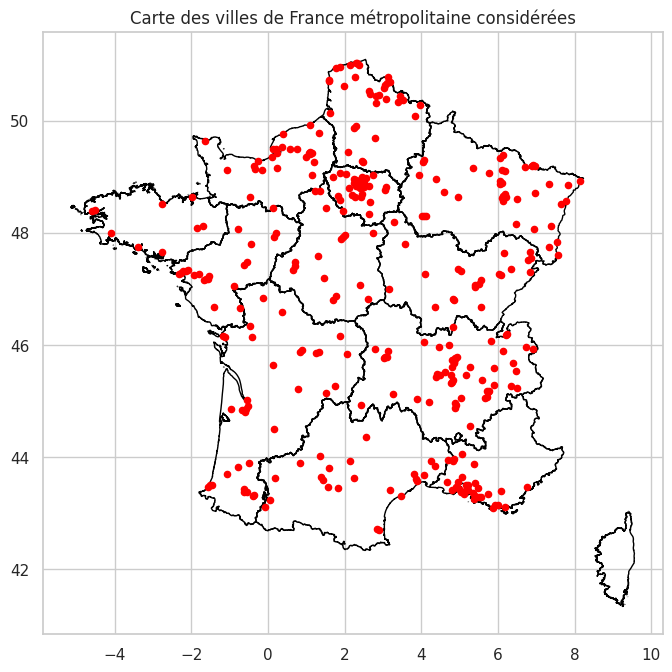

In [6]:
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt

france = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "REGION",
      vectorfile_format="geojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)
france = france.loc[france['INSEE_REG']>10]

geodair_villes = geodair[['Ville', 'Latitude_commune', 'Longitude_commune']].drop_duplicates()

geodair_gdf = gpd.GeoDataFrame(
    geodair_villes,
    geometry=gpd.points_from_xy(geodair_villes["Longitude_commune"], geodair_villes["Latitude_commune"]),
    crs="EPSG:4326"
)

ax = france.plot(figsize=(8,8), edgecolor="black", facecolor="none")
geodair_gdf.plot(ax=ax, color="red", markersize=20)

plt.title("Carte des villes de France métropolitaine considérées")
plt.show()

Les données de Geod'air nous permettent donc d'avoir accès à un large panel géographique de villes.

#### Analyse descriptive de la qualité de l'air

Nous pouvons ensuite visualiser les niveaux de pollution par polluant (NOX as NO2, O3, PM2.5 et PM10) dans les différentes villes. 

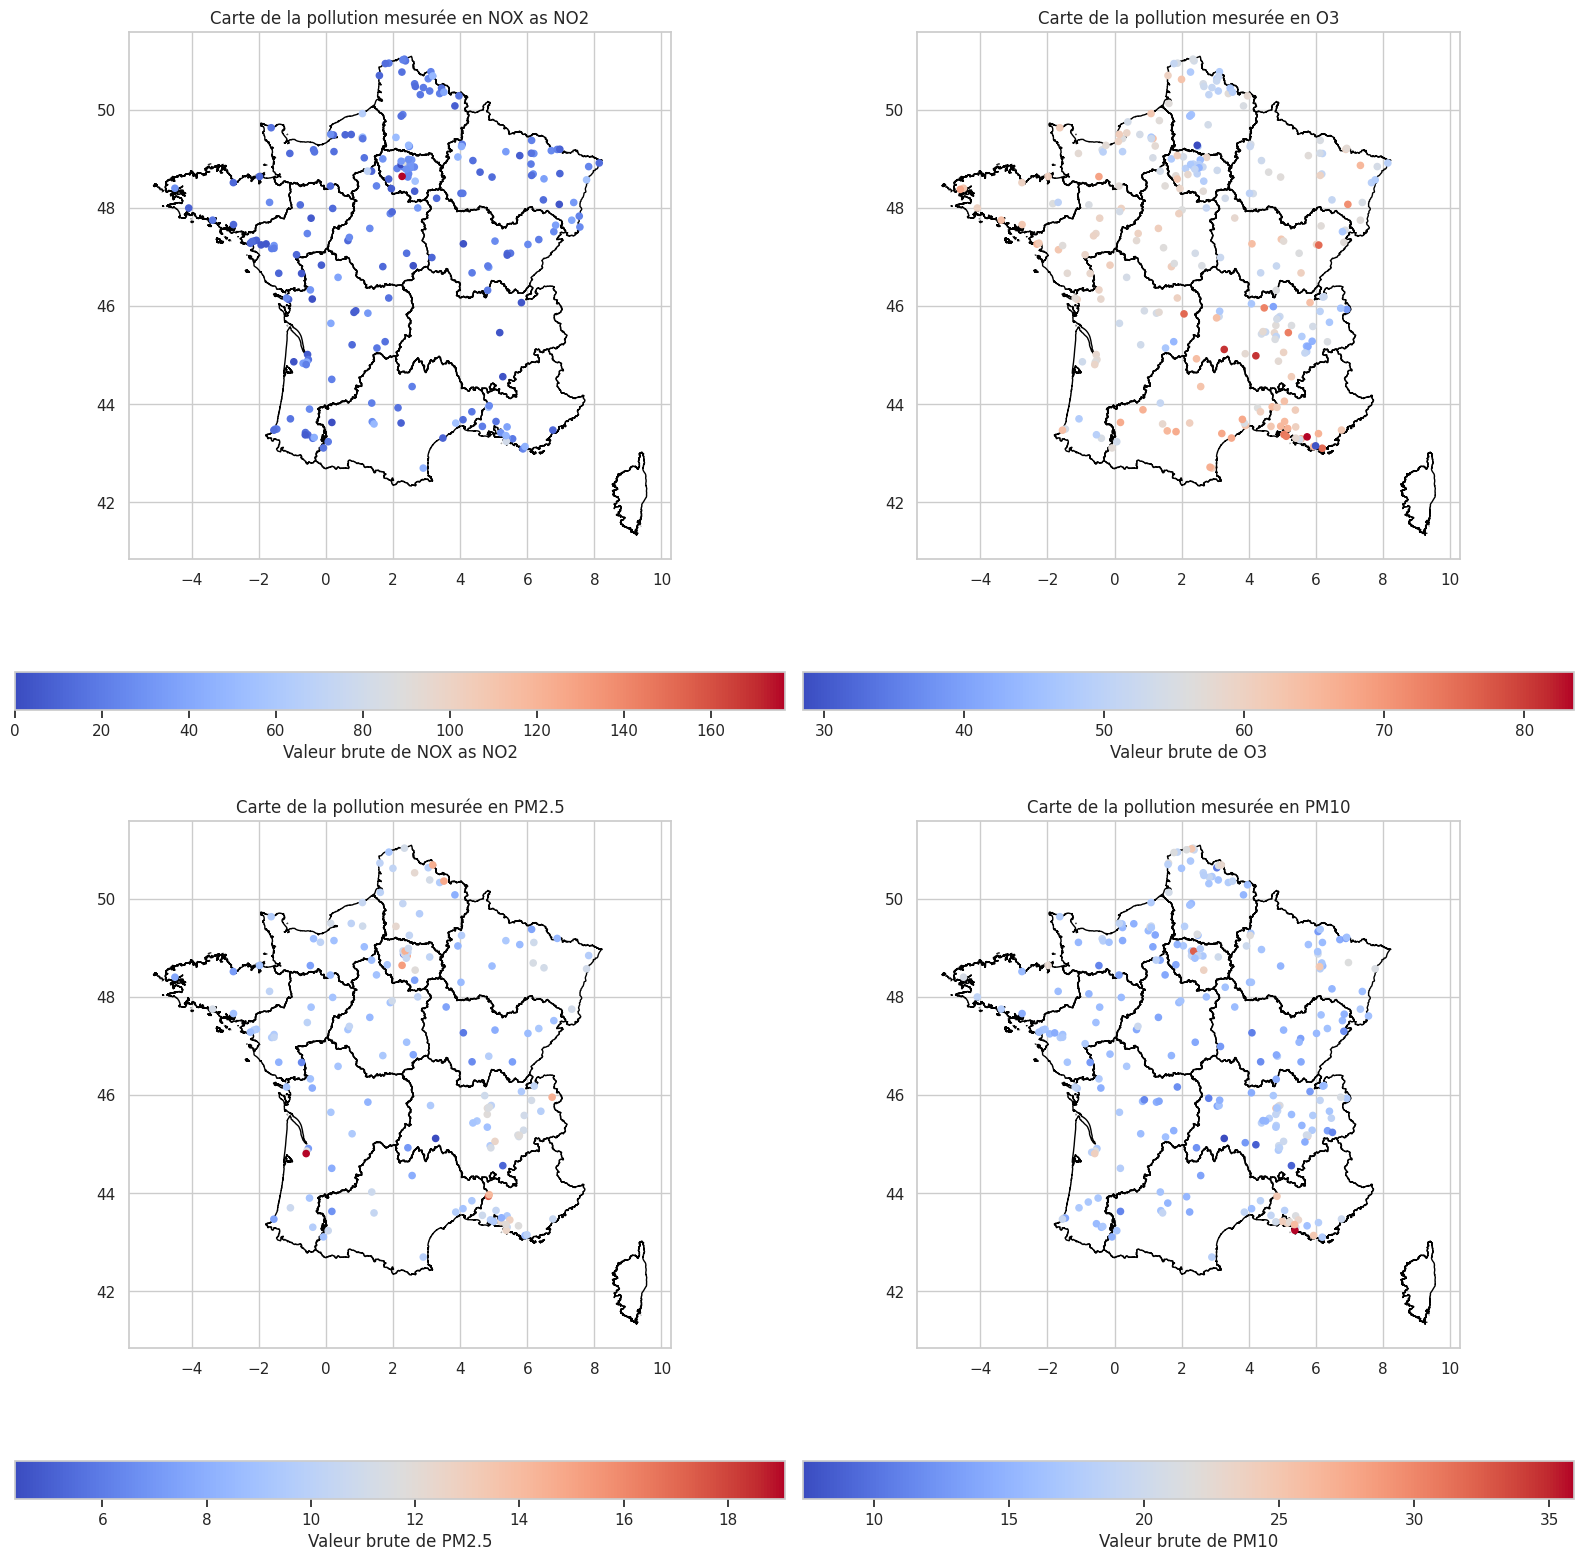

In [7]:
pol_visualization.visualization(geodair)


La qualité de l'air varie donc fortement selon les villes, et ceci différemment en fonction du polluant considéré.

Afin de mettre ces données en perspective, on peut également représenter le respect ou non des seuils de pollution recommandés par l'OMS en 2021, nos données datant de 2022.

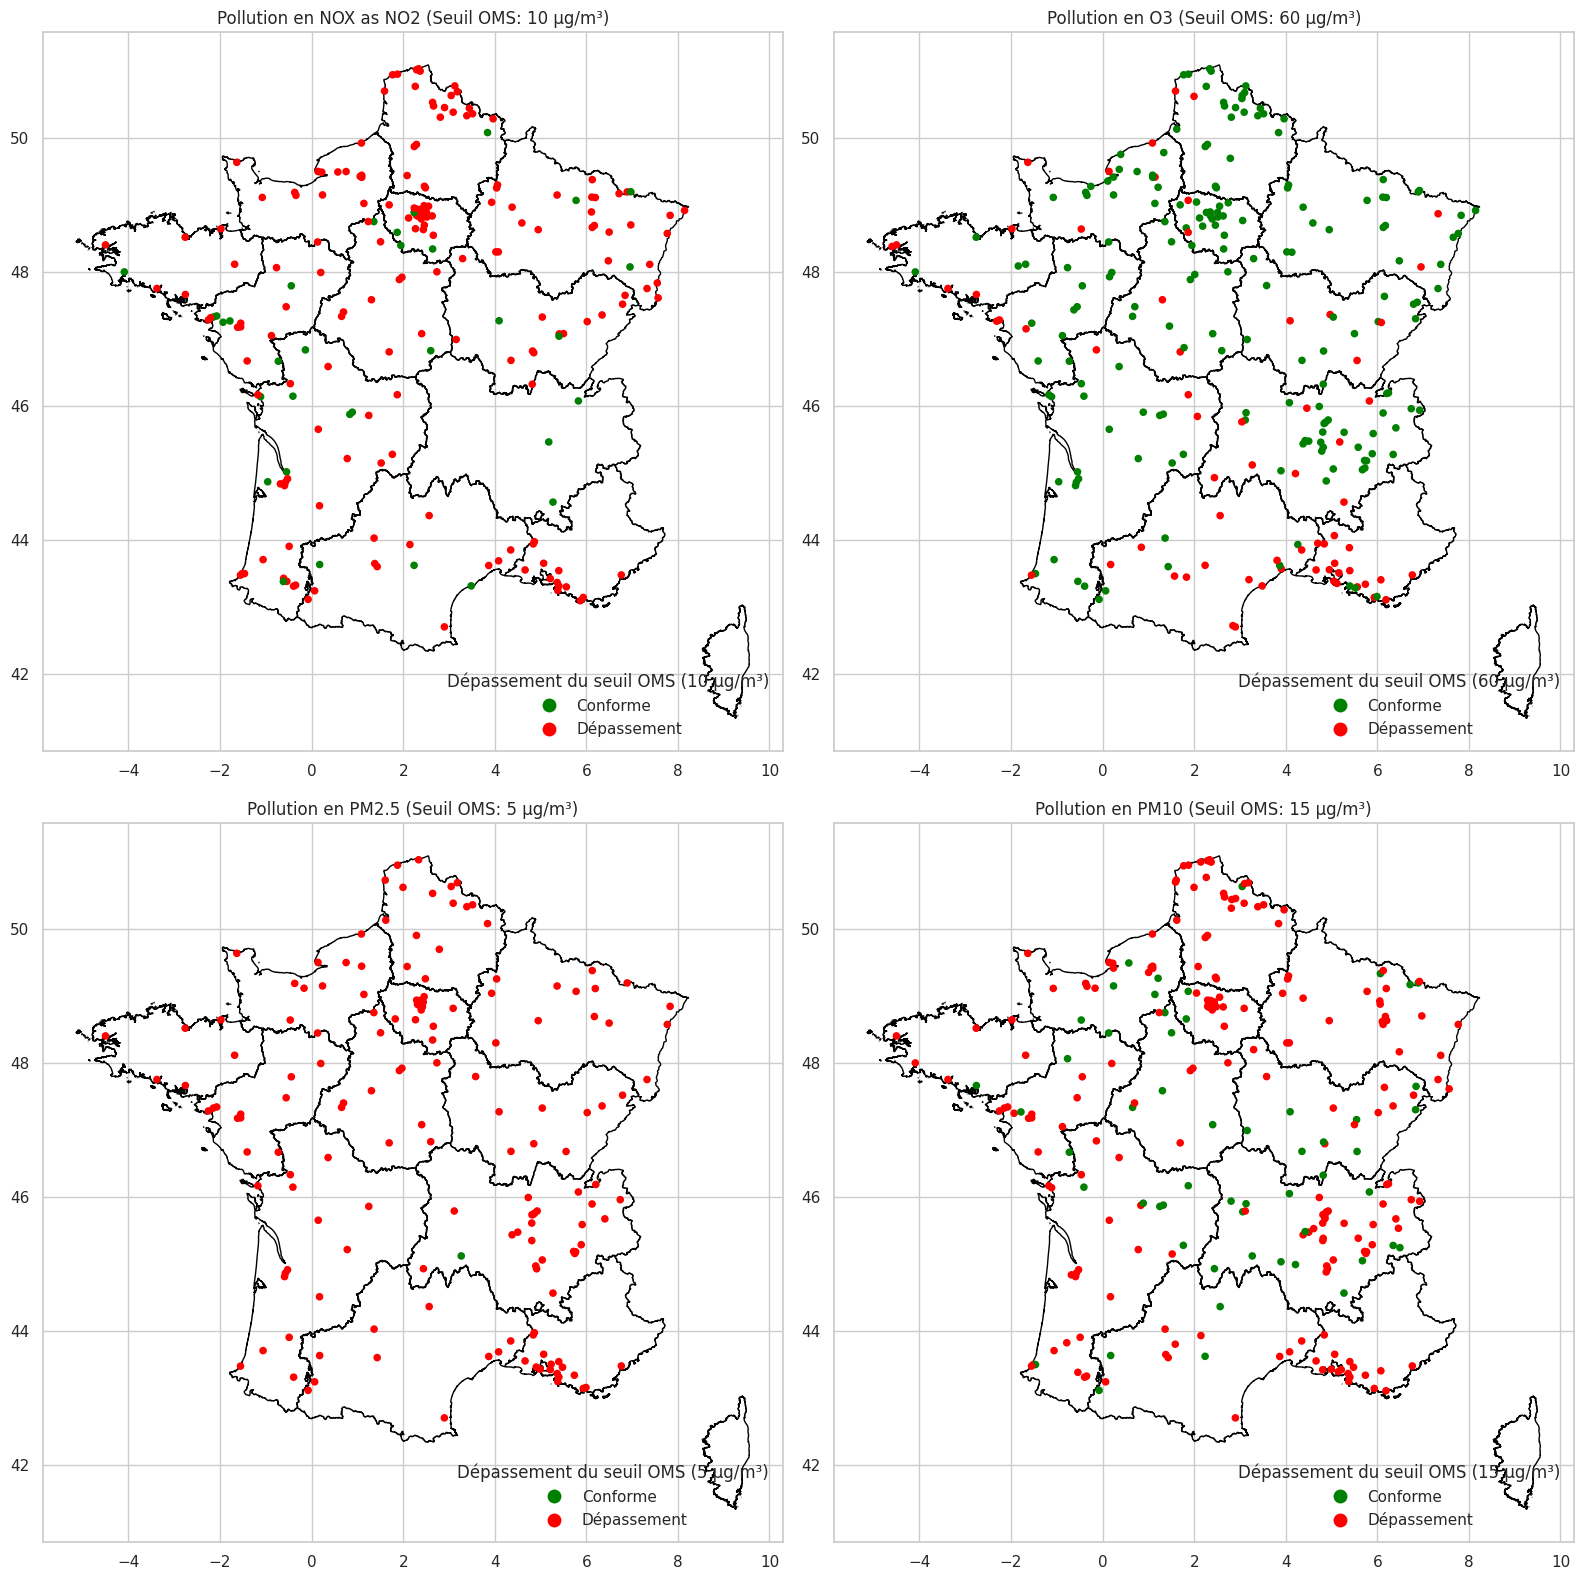

In [ ]:
pol_visualization.visualization_OMS(geodair)

On peut constater que les seuils de pollution recommandés par l'OMS sont dépassés dans de nombreuses villes, et ce pour tous les polluants considérés.

Réduire la pollution est donc une priorité, et déterminer les facteurs démo-éco de la pollution est un premier pas pour résoudre ces problèmes.

### b) Caractéristiques démographiques et économiques des villes de France métropolitaine

#### Chargement et préparation des données

Nos données économiques et démographiques sont divisées en 2 datasets, qu'il convient alors de fusionner pour n'en manipuler qu'un seul, contenant toutes les informations sur les villes. Cette fusion des deux datasets requiert d'être vigilant aux noms et types des variables sur lesquelles s'opère la jointure. A ce titre, des conversions de des renommages sont effectués.

Aussi, le champs de notre étude ne porte que sur les villes en France métropolitaine. Ainsi, les villes de Corse et d'outre-mer sont supprimées de notre base de données.

In [ ]:
# Chargement initial des datasets
df_raw_villes, df_air = prep.load_and_merge_cities(path_air, path_villes, path_tourisme)

print(f"Après fusion : {df_raw_villes.shape[0]} lignes, {df_raw_villes.shape[1]} colonnes")
print(f"Doublons détectés : {df_raw_villes.duplicated().sum()}")
print(f"Nom des colonnes : {list(df_raw_villes.columns)}")

# Nettoyage (Renommage, Typage, Filtrage DOM-TOM)
df_villes_clean = prep.process_city_data(df_raw_villes)

# # Sauvegarde intermédiaire
# df_villes_clean.to_csv("data/processed_data/data_villes_tourisme.csv", index=False)

print(f"Dataset Villes nettoyé : {df_villes_clean.shape}")
display(df_villes_clean.head())

#### Analyse descriptive des villes de France métropolitaine

Commençons par étudier ce dataset contenant des informations sur toutes les villes de France. Cette approche exploratoire nous permettra de construire des éléments de référence pour l'analyse des relevés de pollution. Il s'agit ici de construire des histogrammes pour approximer la distributions de nos variables, ainsi qu'un corrélogramme pour donner un aperçu des relations linéaires qui unissent les variables.

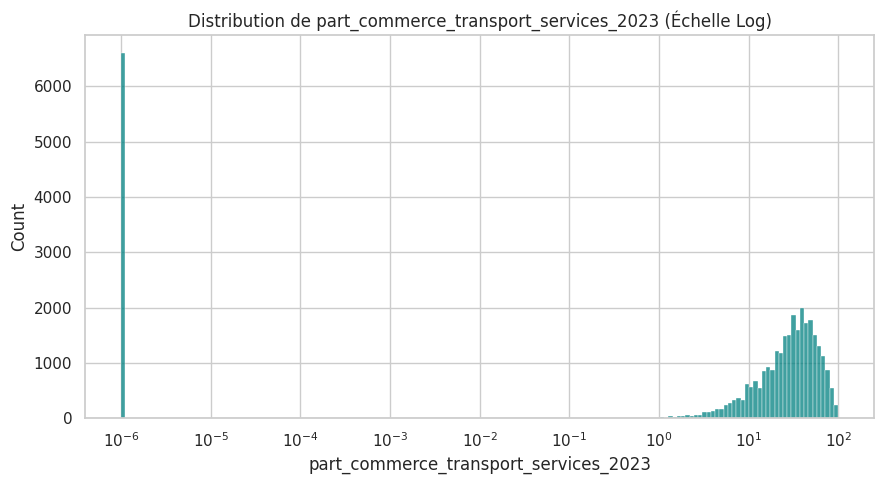

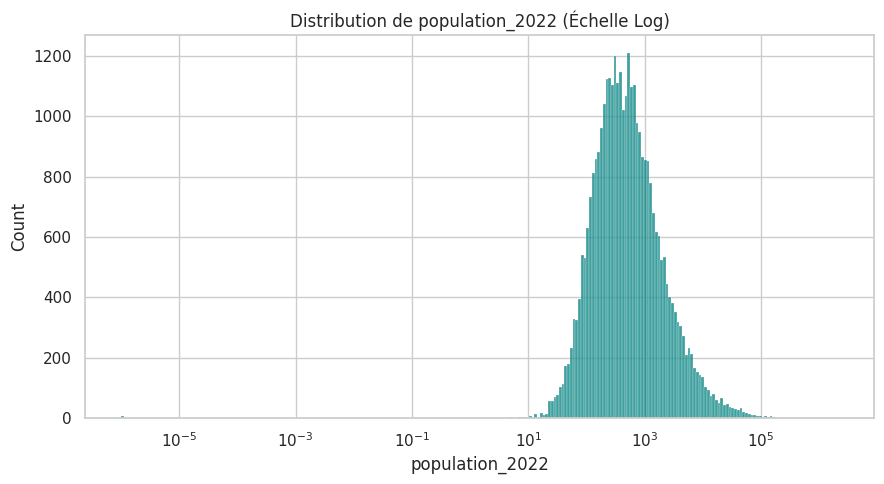

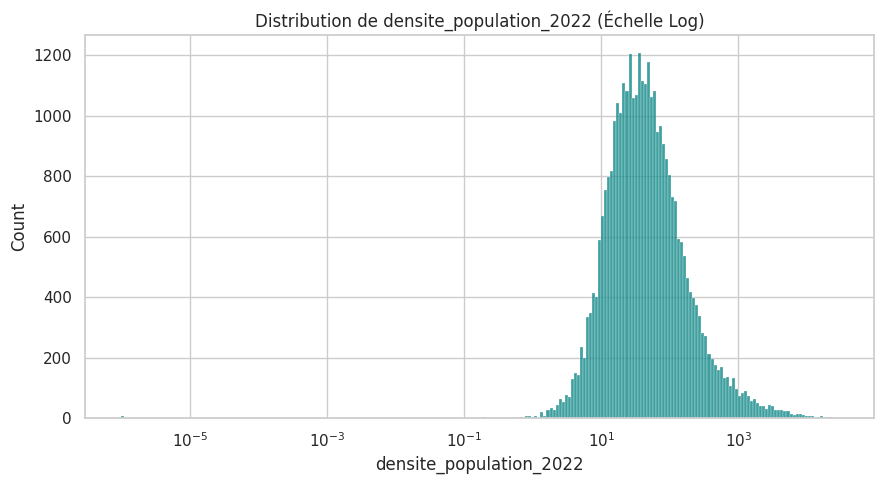

Graphiques de distribution générés dans 'output/Desc_All_Cities'


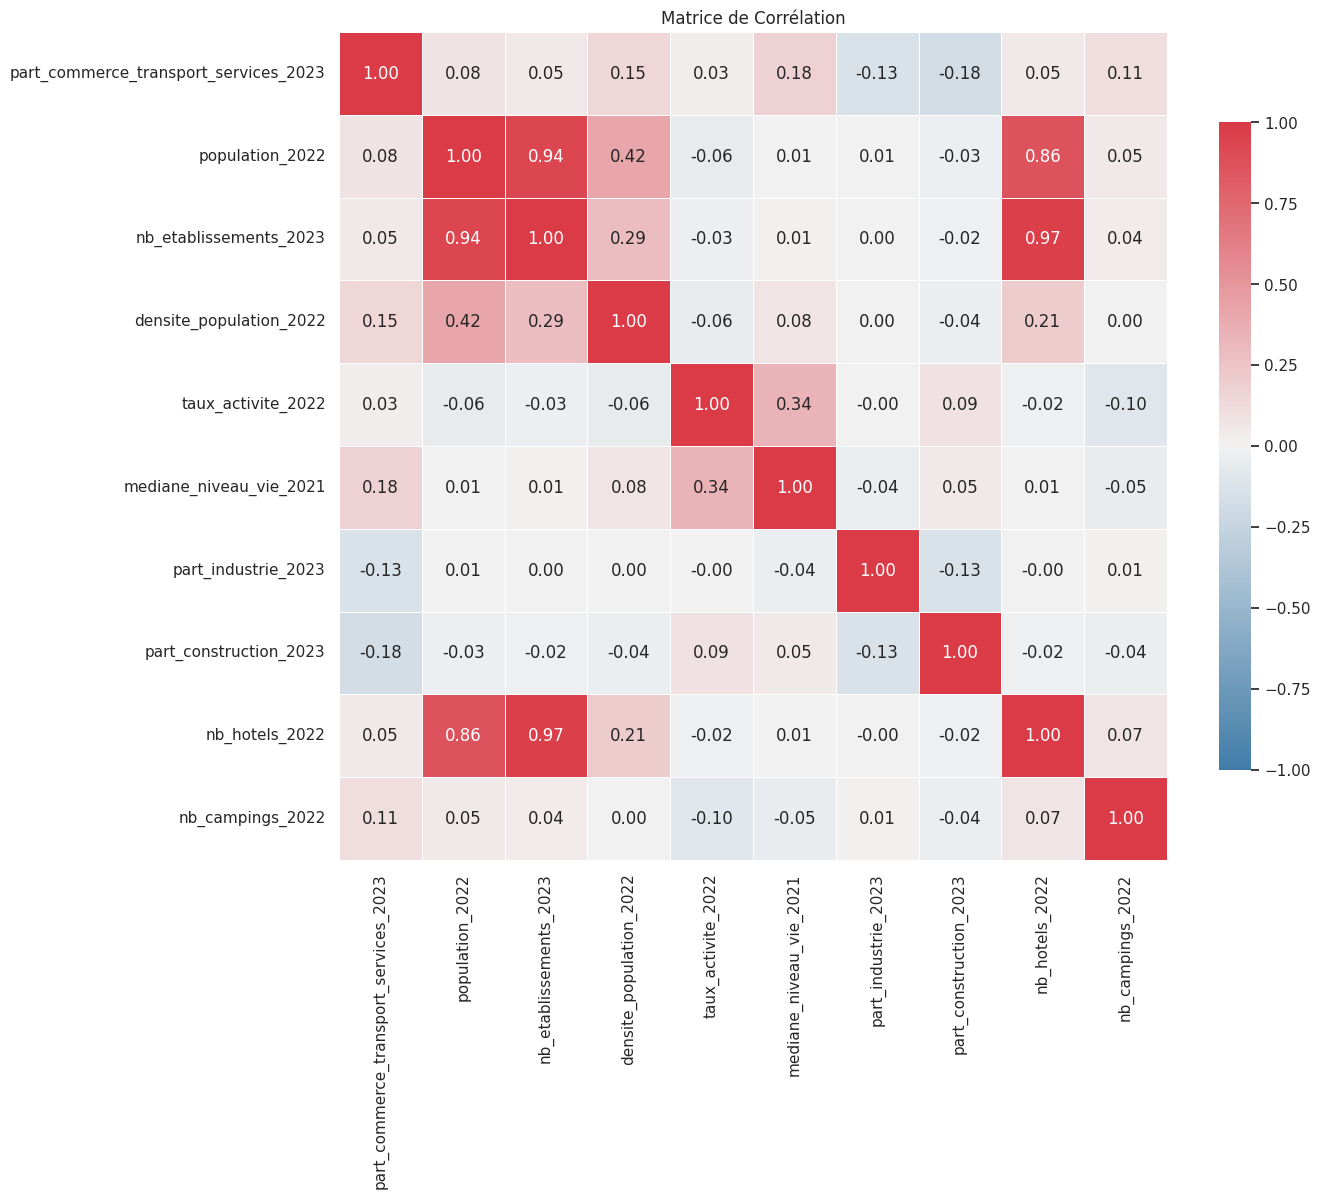

Matrice de corrélation générée.


In [3]:
# Visualisation des distributions
dists_to_save = ['nb_etablissements_2023', 'taux_activite_2022',
                 'mediane_niveau_vie_2021', 'part_industrie_2023',
                 'part_construction_2023', 'nb_hotels_2022', 'nb_campings_2022']
dists_to_save_and_plot = ['part_commerce_transport_services_2023', 'population_2022', 'densite_population_2022']
viz.plot_distributions(df_villes_clean, dists_to_save, display=False)
viz.plot_distributions(df_villes_clean, dists_to_save_and_plot, display=True)

print("Graphiques de distribution générés dans 'output/Desc_All_Cities'")


# Matrice de Corrélation
viz.plot_correlation_heatmap(df_villes_clean, display=True)
print("Matrice de corrélation générée.")

**Analyse des distributions:** On observe que les distributions des variables éco-démo. des villes sont, pour la plupart, de 2 types. En effet, certaines semblent se rapprocher d'une distribution gaussienne (ex: population_2022, densite_population_2022) tandis que d'autres semblent présenter une forte inflation en 0, combinée avec une gaussienne (ex: part_commerce_transport_services_2023). L'étude de toutes les distributions montre que les caractéristiques des villes de France sont très homogènes, avec néanmoins une grande majorité de petites villes rurales avec peu d'activité économique et commerciale (ce qui explique l'inflation en 0 de certaines distributions.)

**Analyse du corrélogramme:** Quelques variables semblent très corrélées (linéairement). En particulier, le nombre d'établissements dans la ville en 2023 est un excellent proxy (presque proportionnel) à la population de cette même ville et à son nombre d'hotels. Remarquons aussi que dans une moindre mesure, les villes les plus peuplées sont aussi les plus denses.

### c) Caractéristiques démographiques et économiques des villes considérées dans notre étude sur la qualité de l'air

#### Fusion des bases de données

Maintenant que nous en savons plus les villes de France, il est temps de comparer avec les villes ayant des stations de mesure. Pour cela, commençons par joindre les données des relevés de pollution avec les données éco-démo des villes dans lesquelles ces relevés sont effectués.

In [ ]:
# 5. Chargement Geodair et Merge
geodair = pd.read_csv("data/processed_data/geodair_2022_villes_codgeo_final.csv", sep=",")
print("Extrait de la base de données GEODAIR:")
display(geodair.head(5))
# Préparation et fusion (gestion des codgeo, types)
df_etude_complete = prep.prepare_geodair_data(geodair, df_villes_clean)
print("Extrait de la base de données d'étude complète:")
display(df_etude_complete.head(5))
# Sauvegarde du dataset complet
df_etude_complete.to_csv("data/processed_data/data_etude_villes_relevees.csv", index=False, sep=";")

print(f"Dataset Étude Complet : {df_etude_complete.shape}")

Extrait de la base de données GEODAIR:


,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude,Ville,CODGEO,Latitude_commune,Longitude_commune
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463.0,49.108113,6.195525
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463.0,49.108113,6.195525
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463.0,49.108113,6.195525
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642.0,49.114042,6.119849
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672.0,49.375972,6.129283


Extrait de la base de données d'étude complète:


,date_debut,date_fin,organisme,code_zas,nom_zas,code_site,nom_site,type_implantation,polluant,type_influence,reglementaire,type_evaluation,type_valeur,valeur,valeur_brute,unite,taux_saisie,couverture_temporelle,couverture_donnees,code_qualite,validite,latitude_site,longitude_site,ville,codgeo,latitude_commune,longitude_commune,nom_commune,part_commerce_transport_services_2023,population_2022,nb_etablissements_2023,densite_population_2022,taux_activite_2022,mediane_niveau_vie_2021,part_industrie_2023,part_construction_2023,nb_hotels_2022,nb_campings_2022
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525,Metz,45.8,121695.0,5203.0,2901.6,70.9,20940.0,4.6,3.6,26.0,1.0
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525,Metz,45.8,121695.0,5203.0,2901.6,70.9,20940.0,4.6,3.6,26.0,1.0
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525,Metz,45.8,121695.0,5203.0,2901.6,70.9,20940.0,4.6,3.6,26.0,1.0
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642,49.114042,6.119849,Scy-Chazelles,67.8,2665.0,80.0,589.6,75.3,28380.0,0.3,7.9,0.0,0.0
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672,49.375972,6.129283,Thionville,43.8,42778.0,1494.0,857.6,77.0,24850.0,6.4,2.9,8.0,1.0


Dataset Étude Complet : (2034, 38)


#### Analyse comparative des villes de notre étude avec les villes de France métropolitaine

Enfin, avant de mener nos analyses, remarquons que certaines villes possèdent plusieurs points de mesure. Pour n'avoir qu'un point par ville et par polluant, on agrège les valeurs des relevés au sein d'une même ville en prenant la moyenne de ceux-ci.

In [5]:
# Agrégation par Polluant et Ville
df_groupe = prep.aggregate_by_pollutant(df_etude_complete)

polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")

Polluants identifiés : ['NOX as NO2' 'O3' 'PM10' 'PM2.5']


Pour chacun de nos 4 polluants, nous étudions l'échantillon de villes associé. Pour préparer les analyses suivantes, nous divisons notre dataset en 4 (un dataset par polluant).

Pour les analyses, nous comparons:

- Le proportion de petites/moyennes/grandes villes de nos échantillons
- Les moyennes des variables éco-démo.
- Les distributions des variables éco-démo.

Polluants identifiés : ['NOX as NO2' 'O3' 'PM10' 'PM2.5']
--- Traitement : NOX as NO2 ---

>> Distribution par taille de ville pour : NOX as NO2


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),26,12.21,7.731
Petite (2-10k),30,14.08,20.833
Moyenne (10-50k),87,40.85,22.546
Grande (>50k),70,32.86,32.191


--- Traitement : O3 ---

>> Distribution par taille de ville pour : O3


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),44,16.73,62.545
Petite (2-10k),46,17.49,56.457
Moyenne (10-50k),109,41.44,54.917
Grande (>50k),64,24.33,55.917


--- Traitement : PM10 ---

>> Distribution par taille de ville pour : PM10


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),25,9.69,14.240
Petite (2-10k),46,17.83,16.957
Moyenne (10-50k),114,44.19,17.009
Grande (>50k),73,28.29,18.533


--- Traitement : PM2.5 ---

>> Distribution par taille de ville pour : PM2.5


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),20,12.05,8.050
Petite (2-10k),15,9.04,10.100
Moyenne (10-50k),70,42.17,9.979
Grande (>50k),61,36.75,10.295


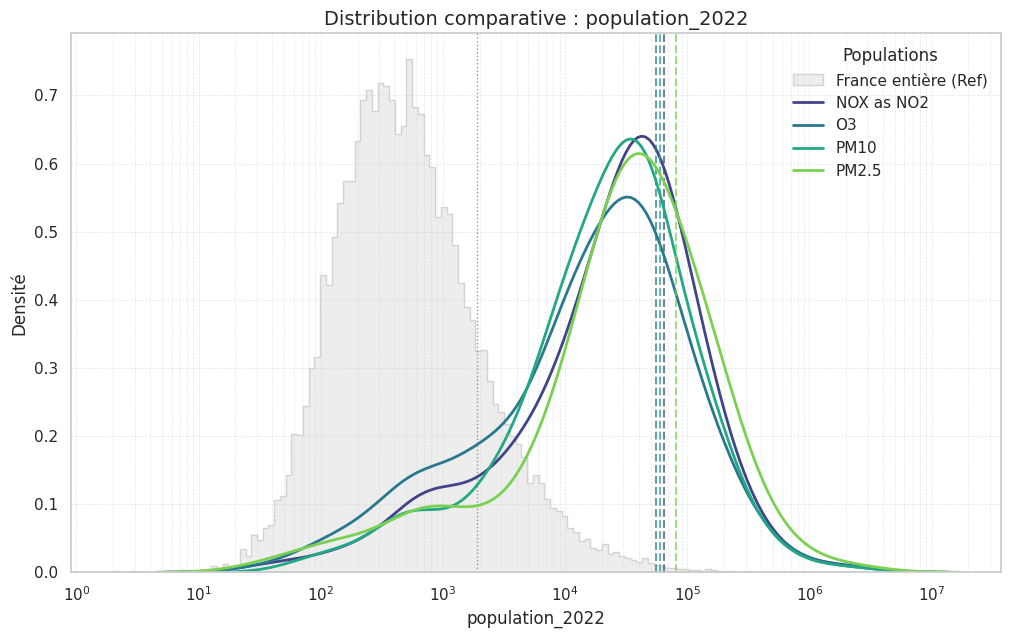

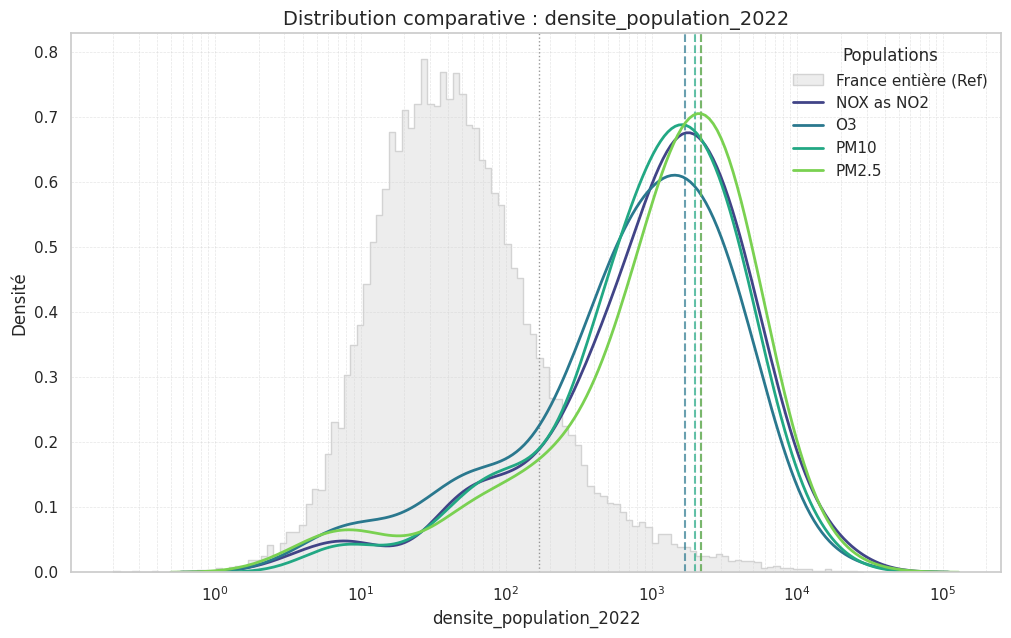

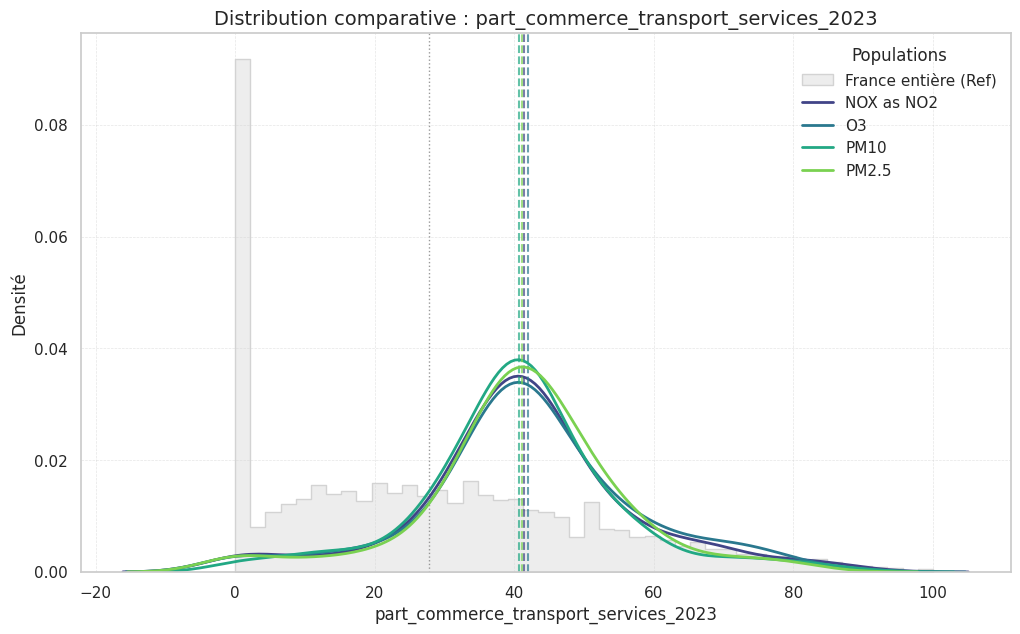

Graphiques générés dans : output/plots_comparaison

Analyse terminée. Tous les graphiques sont générés.


In [6]:
polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")
# Génération des Datasets par Polluant et Plots Comparatifs
vars_eco = {
    "population_2022": True,
    "mediane_niveau_vie_2021": False,
    "densite_population_2022": True,
    "part_commerce_transport_services_2023": True,
    "part_industrie_2023": False,
    "nb_hotels_2022": False,
    "nb_etablissements_2023": False,
    "taux_activite_2022": False,
    "part_construction_2023": False,
    "nb_campings_2022": False
}

df_combined = {}
for pol in polluants:
    print(f"--- Traitement : {pol} ---")
    
    # Filtre et Sauvegarde
    df_pol = df_groupe[df_groupe["polluant"] == pol]
    df_pol.to_csv(f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv", index=False, sep=';')
    df_combined[pol] =df_pol
    # Comparaison des proportions de petites, moyennes et grandes villes
    stats = prep.analyze_city_size_distribution(df_pol, pol)
    display(stats)
    
    # Plots Comparatifs (France vs Echantillon)
    viz.plot_comparative_distributions(
        df_sample=df_pol, 
        df_france=df_villes_clean, 
        polluant_name=pol, 
        vars_eco=vars_eco,
    )

    # Etude des corrélations entre la concentration de polluant et les variables éco-démo.
    viz.plot_correlation_heatmap(df_pol, pol=pol)

viz.plot_combined_distributions_per_var(df_combined, df_villes_clean, vars_eco,)
print("\nAnalyse terminée. Tous les graphiques sont générés.")

**Analyse des tableaux récapitulatifs:** On remarque que les échantillons de chaque polluant comportent globalement les mêmes proportions de chaque taille de ville. En particulier, les moyennes et grandes villes sont majoritaires dans nos échantillons, et donc sur-représentées par rapport à la distribution de toutes les villes de France. Nos échantillons ne sont donc pas représentatifs des villes françaises, mais cela ne pose pas de problème pour les analyses à suivre.

De plus, remarquons que seuls les "NOX as NO2" semblent être dépendant de la taille de la ville. Ce constat est attendu car ce polluant est principalement émis par le transport routier et le secteur industriel. A l'inverse, l'O3, les PM2.5 et les PM10 sont des polluants eux aussi d'origine humaine, mais que l'on pourrait qualifier d'indirects, ie. formés à l'issue de réactions chimiques post-émissions. A ce titre, la corrélation entre concentration de ces polluants et taille de la ville.

**Analyse des graphes:** Ces graphiques donnent des informations plus précises sur les différences entre nos échantillons et l'ensemble des villes de France. Ces graphes confirment les analyses précédentes:

- Les distributions pour chaque polluant sont très semblables
- Les distributions des variables éco-démo des villes dans les échantillons de chaque polluant sont différentes de celles pour toutes les villes de France. En particulier, la grande proportion de villes moyennes et grandes est visible.

## Partie 2: Modélisation

### a) Modélisation par arbres

Dans cette partie, nous tentons d'expliquer/prédire la qualité de l'air observée dans une ville à l'aide de ses caractéristiques éco-démo. Seuls les arbres CART seront considérés. En effet, il n'est pas envisageable d'aller plus loin avec des Random Forest faute d'observations (Autour de 200 observations par polluant).

In [14]:
# Configuration
polluants = ["NOX as NO2", "O3", "PM10", "PM2.5"]
# Liste des variables explicatives initiales
features_base = [
    "population_2022", 
    "mediane_niveau_vie_2021",
    "densite_population_2022",
    "part_commerce_transport_services_2023",
    "part_industrie_2023", 
    "part_construction_2023", 
    "taux_activite_2022",
    "nb_etablissements_2023",
    "nb_campings_2022",
    "nb_hotels_2022"
]
# On enlève campings et hotels qui n'apportent souvent que du bruit par rapport aux établissements globaux
target = "valeur"
seed = 2003
results_table = []

# Seuil de corrélation un peu plus strict car on va générer beaucoup de bruit potentiel
CORR_THRESHOLD = 0.12 

Pour maximiser la performance de l'Arbre de Décision, nous avons mis en place une chaîne de traitement robuste adaptée à la nature non-linéaire et bruitée des données socio-économiques.

1. Imputation par la Médiane Les algorithmes d'arbres (CART) de Scikit-Learn ne gèrent pas les valeurs manquantes. Nous remplaçons les NaN par la médiane de chaque variable plutôt que par la moyenne. Ce choix est crucial car nos variables (comme la population ou la densité) présentent des distributions asymétriques avec des valeurs extrêmes ; la médiane est plus robuste et évite d'introduire un biais artificiel dans les données.

2. Génération d'Interactions (Polynomiales) La pollution est rarement causée par un facteur isolé, mais par la synergie entre plusieurs variables. Nous générons des "features polynomiales" (degré 2) pour créer explicitement des termes d'interaction (ex: Densité × Industrie). Cela permet à l'arbre de capter directement ces effets multiplicateurs complexes, qu'il peinerait autrement à modéliser sans devenir excessivement profond et sujet au sur-apprentissage.

3. Transformation Logarithmique de la Cible Les concentrations de polluants suivent une distribution log-normale : une majorité de valeurs faibles et quelques pics très élevés. L'entraînement sur les données brutes force le modèle à se focaliser excessivement sur ces pics (outliers). En appliquant une transformation logarithmique (np.log1p) sur la cible, nous compressons l'échelle et stabilisons la variance , permettant au modèle d'apprendre la structure globale des données de manière plus équilibrée.

4. Filtrage par Corrélation de Spearman L'étape de génération d'interactions crée de nombreuses variables, dont certaines ne sont que du bruit. Pour éviter l'overfitting, nous appliquons un filtre strict : seules les variables ayant une corrélation de Spearman supérieure à 0.12 avec la cible sont conservées. Nous utilisons Spearman (basé sur les rangs) car cette méthode détecte les relations monotones même non-linéaires, garantissant que l'arbre ne reçoit que des signaux prédictifs robustes.


PROCESSING: NOX as NO2
Variables générées : 65 (Initiales + Interactions)
Top 3 variables corrélées : 
population_2022 densite_population_2022    0.689065
densite_population_2022^2                  0.682578
densite_population_2022                    0.682578
Variables RETENUES pour le modèle : 52


R2 Final: 0.275


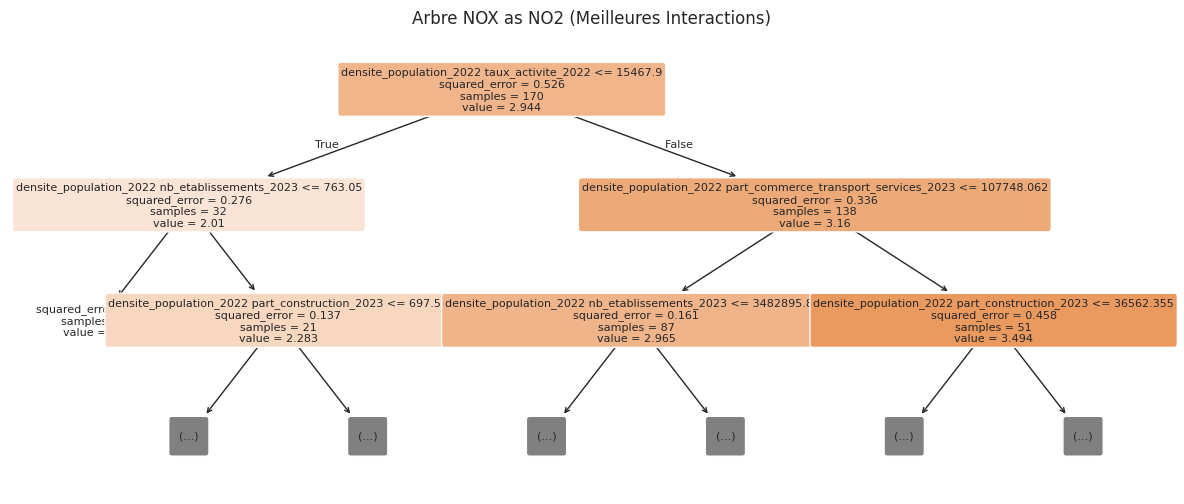


PROCESSING: O3
Variables générées : 65 (Initiales + Interactions)
Top 3 variables corrélées : 
densite_population_2022                       0.364930
densite_population_2022^2                     0.364930
densite_population_2022 taux_activite_2022    0.364371
Variables RETENUES pour le modèle : 41
R2 Final: 0.208


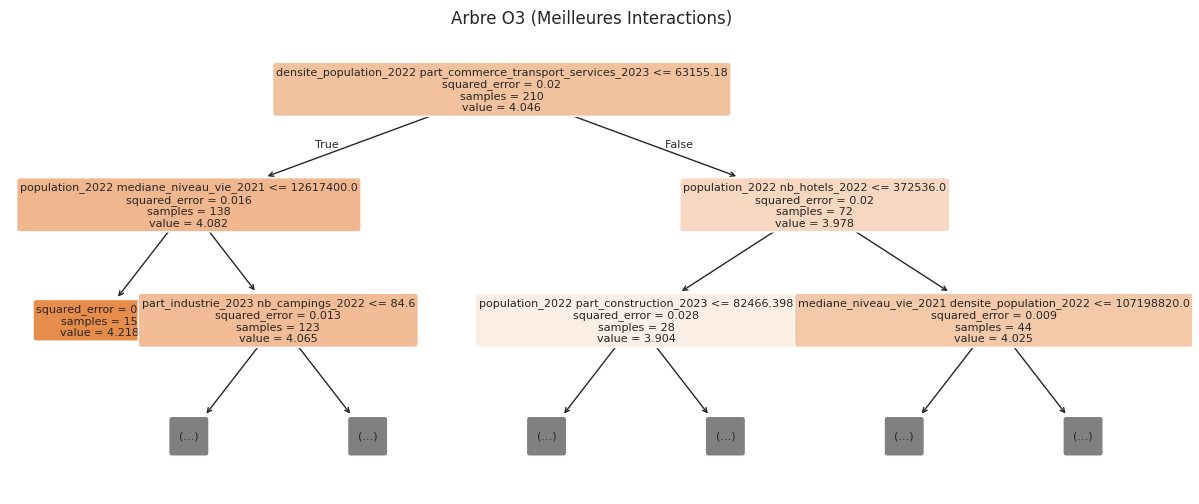


PROCESSING: PM10
Variables générées : 65 (Initiales + Interactions)
Top 3 variables corrélées : 
densite_population_2022 part_construction_2023                   0.417591
population_2022 part_construction_2023                           0.400001
densite_population_2022 part_commerce_transport_services_2023    0.357006
Variables RETENUES pour le modèle : 39
R2 Final: -0.032


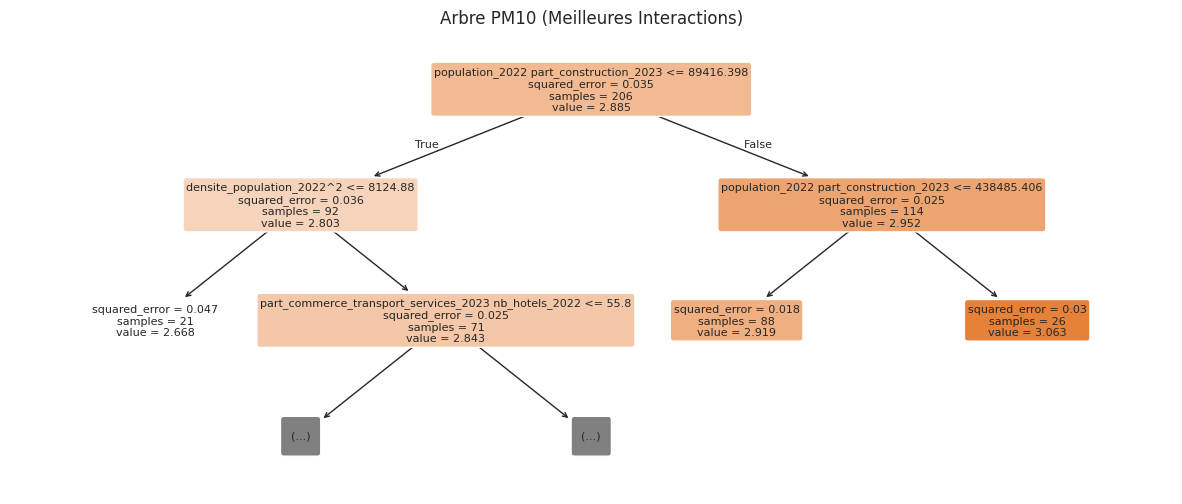


PROCESSING: PM2.5
Variables générées : 65 (Initiales + Interactions)
Top 3 variables corrélées : 
densite_population_2022 part_construction_2023                   0.458177
densite_population_2022 part_commerce_transport_services_2023    0.405325
densite_population_2022 taux_activite_2022                       0.400677
Variables RETENUES pour le modèle : 38
R2 Final: 0.192


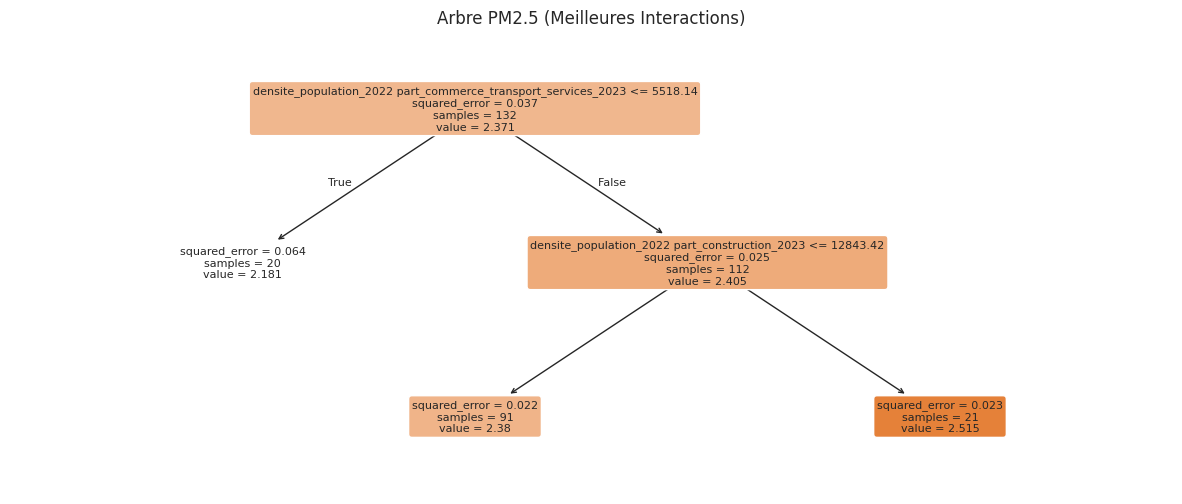


##############################
 Résultats finaux (Polynomial + Filter) 
##############################


,Pollutant,R2 Score,RMSE,MAE,Best Depth,Feats Kept
0,NOX as NO2,0.275,15.205,9.838,5,52
1,O3,0.208,5.948,4.556,5,41
3,PM2.5,0.192,1.465,1.174,5,38
2,PM10,-0.032,3.603,2.836,5,39


In [15]:
for pol in polluants:
    print(f"\n{'='*40}")
    print(f"PROCESSING: {pol}")
    
    # 1. Import
    file_path = f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv"
    df = pd.read_csv(file_path, sep=';')
    
    X = df[features_base].copy()
    
    # Gestion NaN
    if X.isna().sum().sum() > 0:
        X = X.fillna(X.median())

    # --- ETAPE 2 : GENERATION D'INTERACTIONS (POLYNOMIAL) ---
    # degree=2 génère : Les variables, leurs carrés (A^2), et leurs interactions (A*B)
    # include_bias=False pour ne pas avoir une colonne de "1"
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly_array = poly.fit_transform(X)
    
    # On remet ça dans un DataFrame propre avec les noms des colonnes
    new_feature_names = poly.get_feature_names_out(features_base)
    X_poly = pd.DataFrame(X_poly_array, columns=new_feature_names, index=X.index)
    
    print(f"Variables générées : {X_poly.shape[1]} (Initiales + Interactions)")

    # Préparation Cible (Log)
    y = df[target]
    y_log = np.log1p(y)

    # --- ETAPE 3 : FILTRAGE PAR CORRELATION (CRUCIAL) ---
    analysis_df = X_poly.copy()
    analysis_df['target_log'] = y_log
    
    # Spearman capture les relations non-linéaires
    correlations = analysis_df.corr(method='spearman')['target_log'].drop('target_log').abs()
    
    # On trie pour voir les meilleures
    top_features = correlations.sort_values(ascending=False).head(15) # On regarde le top 15 pour info
    print(f"Top 3 variables corrélées : \n{top_features.head(3).to_string()}")

    # Sélection stricte
    features_kept = correlations[correlations >= CORR_THRESHOLD].index.tolist()
    
    # Sécurité : Si on a trop filtré, on garde au moins les 5 meilleures
    if len(features_kept) < 2:
        print("ATTENTION : Filtre trop strict. On garde les 5 meilleures variables.")
        features_kept = correlations.sort_values(ascending=False).head(5).index.tolist()
    
    print(f"Variables RETENUES pour le modèle : {len(features_kept)}")
    
    X_final = X_poly[features_kept]

    # 4. Split
    X_train, X_test, y_train_log, y_test_log = train_test_split(X_final, y_log, test_size=0.2, random_state=seed)
    _, _, _, y_test_real = train_test_split(X_final, y, test_size=0.2, random_state=seed)

    # 5. Grid Search (Paramètres affinés pour gérer les nouvelles variables)
    param_grid = {
        'max_depth': [5, 7, 10, 12, 15], 
        'min_samples_split': [10, 20, 40], # On augmente un peu pour éviter l'overfitting sur les interactions
        'min_samples_leaf': [5, 10, 20],
        'ccp_alpha': [0.0, 0.0005, 0.001]
    }
    
    model = DecisionTreeRegressor(criterion="squared_error", random_state=seed)
    
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train_log)
    
    best_model = grid.best_estimator_
    
    # Prédiction
    y_pred_log = best_model.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    
    # Métriques
    r2 = r2_score(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)
    
    results_table.append({
        "Pollutant": pol,
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "Best Depth": best_model.max_depth,
        "Feats Kept": len(features_kept)
    })
    
    print(f"R2 Final: {r2:.3f}")
    
    # Affichage de l'arbre (Top 3 niveaux) pour voir quelle interaction gagne
    plt.figure(figsize=(15, 6))
    plot_tree(best_model, feature_names=features_kept, filled=True, rounded=True, max_depth=2, fontsize=8)
    plt.title(f"Arbre {pol} (Meilleures Interactions)")
    plt.show()

print("\n" + "#"*30)
print(" Résultats finaux (Polynomial + Filter) ")
print("#"*30)
df_results = pd.DataFrame(results_table).sort_values(by="R2 Score", ascending=False)
display(df_results)

##### **Analyse des arbres**

**NOX as NO2:**
Cet arbre est de loin le plus performant car il explique plus de 20% de la variance de la concentration de polluant. Les variables les plus déterminantes pour expliquer la concentration de NOX as NO2 dans l'air sont la densité de population, la population et la part d'établissements dédiés à la construction en ville. Ces constats sont cohérents avec les analyses descriptives précédentes.

**Autres polluants:**
On constate que la densité de population revient systématique parmi les facteurs principaux d'explication de la concentration des polluants dans l'air. 

Néanmoins, pour ces polluants, la qualité de la modélisation est particulièrement mauvaise.
Notre hypothèse est que nous tentons d'expliquer la concentration de ces polluants dans l'air, un phénomène très complexe et multifactoriel, par un nombre très restreint de variables. Des variables relatives à la météorologie, l'agriculture, la topographie des lieux sont aussi essentiels pour une modélisation plus proche du réel.

NB: certains modèles d'arbres peuvent présenter des R2 négatifs. Cela est tout à fait possible compte-tenu de la définition du R2 retenue par scikit-learn ici. Cela indique notamment que les performances du modèle sont pires que celles d'un modèle qui prédirait la moyenne de l'échantillon 100% du temps.